In [64]:
import os
import json
import math
import datetime
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt
%matplotlib inline

# NOTE: put this notebook in the same directory as the logs
# Load logs from JSON into list of dictionaries
folderPath = os.path.pardir + '/logs 170928'
files = [os.path.join(folderPath, f) for f in next(os.walk(folderPath))[2]]
print files

['../logs 170928/.DS_Store', '../logs 170928/0', '../logs 170928/10', '../logs 170928/12', '../logs 170928/13', '../logs 170928/14', '../logs 170928/15', '../logs 170928/17', '../logs 170928/18', '../logs 170928/19', '../logs 170928/2', '../logs 170928/20', '../logs 170928/20170928 mouse condition.png', '../logs 170928/20170928 mouse movements.png', '../logs 170928/20170928 mouse user.png', '../logs 170928/20170928_0736_split.csv', '../logs 170928/20170928_0736_stacked.csv', '../logs 170928/21', '../logs 170928/22', '../logs 170928/3', '../logs 170928/4', '../logs 170928/5', '../logs 170928/6', '../logs 170928/8', '../logs 170928/9']


In [213]:
# Function to extract coorinates as 2 x number of steps array
def get_coords(mouse):
    # Empty array
    coords = np.zeros((2, len(mouse)))
    times = np.zeros( len(mouse) )

    # Load coordinates into array 
    for i, t in enumerate(mouse):
        # Note that becuase web axis are left-down, we invert the y
        coords[0,i] = t['x']
        coords[1,i] = -t['y']
        times[i] = t['time']

    # Subtract start from all points to center at 0,0
    x_start, y_start = coords[0,0], coords[1,0]
    coords -= np.array([[x_start],[y_start]])
    
    # Subtract start from all times
    times = times - times[0]
    
    # Return our coordinate array
    return coords, times

In [8]:
# Function to rotate coordinates so start and end are on x-axis
def rot_coords(coords):

    # Get start and end for angle
    x_start, y_start = coords[0,0], coords[1,0]
    x_end, y_end = coords[0,-1], coords[1,-1]

    # Some trig to make rotation matrix... SOHCAHTOA! SOHCAHTOA! SOHCAHTOA!
    r = -math.atan2((y_end-y_start),(x_end-x_start))
    R = np.array([[math.cos(r), -math.sin(r)],[math.sin(r), math.cos(r)]])
    
    # Return the rotated coordiantes and the maximnum absolute y value
    rotated = np.matmul(R, coords)
    max_y = np.abs(rotated[1,:]).max()
    
    return rotated, max_y

In [23]:
# Empty array for all log files
tests = []

# Load in logs
for f in files:
    if all( word not in os.path.basename(f) for word in ['.DS_Store', '.gitignore','.png', '.csv']) :
        print "Loading log %s" % os.path.basename(f)
        with open(f, 'r') as f:
            data = json.load(f)
            tests.append(data)

Loading log 0
Loading log 10
Loading log 12
Loading log 13
Loading log 14
Loading log 15
Loading log 17
Loading log 18
Loading log 19
Loading log 2
Loading log 20
Loading log 21
Loading log 22
Loading log 3
Loading log 4
Loading log 5
Loading log 6
Loading log 8
Loading log 9


In [379]:
# Empty arrays to construct our dataframe (or numpy array)
name = []
device = []
image = []
flag = []
action = []
mouse = []
cat = []
all_coords = []
all_times = []

# Loop over every test in logs
for test in tests:
    # Loop over every iamge in logs 
    for img in test['experiment']:
        if img['dataType'] == "trial":
            
            # Load relevant data into array
            name.append(test['name'])
            device.append(test['device'])
            flag.append(img['flag'])
            
            # For images, label sd actual o fake
            if 'not' in img['trialImage']:
                image.append(False)
            else:
                image.append(True)
            
            # For 'owl' or warmup category
            if 'owl' in img['trialImage']:
                cat.append("owl")
            elif 'elvis' in img['trialImage']:
                cat.append('elvis')
            elif 'hot' in img['trialImage']:
                cat.append('hot_dog')
            elif 'dog' in img['trialImage']:
                cat.append('dog')
            
            # For action
            if img['action'] == 'optionA':
                action.append(True)
            else:
                action.append(False)
                
            # Get maximum deviation in rotated coordinated 
            coords, times = get_coords(img['mouse'])
            coords2, max_y = rot_coords(coords)
            times = normalize_time(times)
            
            all_times.append(times)
            all_coords.append(coords2)
            mouse.append(max_y)

In [380]:
def normalize_time( times ):
    times = times / times.max()
    return times

In [381]:
# Function to classify test condition
def classify_condition(df):
    if df.image and df.flag:
        return 'imgT_aiT'
    elif df.image and not df.flag:
        return  'imgT_aiF'
    elif not df.image and df.flag:
        return  'imgF_aiT'
    elif not df.image and not df.flag:
        return  'imgF_aiF'

In [382]:
# Function to classify test condixtion
def classify_condition2(df):
    if df.image and df.flag:
        return 'aligned'
    elif df.image and not df.flag:
        return  'not-aligned'
    elif not df.image and df.flag:
        return  'not-aligned'
    elif not df.image and not df.flag:
        return  'aligned'

In [485]:
# Construct a Pandas dataframe in case we want to do maths
df = pd.DataFrame({'name':name, 'image':image, 'flag':flag, 'action':action, 'mouse':mouse, 'device':device, 'cat': cat})
df = df[df.name != 'RG']
df = df[df.name != 'MDR-touchpad']

In [498]:
def get_stats ( series ):
    mean = series.mean()
    sd = series.std()
    se = series.std() / np.sqrt(series.shape[0])
    conf = series.std() / np.sqrt(series.shape[0]) * 1.96
    print "mean:",mean
    print "SD:",sd
    print "SE:",se
    print "95%:",conf
    
    return mean, sd, se, conf

CORRECT ACTIONS - MEAN MOUSE MVMT
mean: 139.673806443
SD: 135.7415683
SE: 5.33655171249
95%: 10.4596413565

INCORRECT ACTIONS - MEAN MOUSE MVMT
mean: 185.57783779
SD: 144.57988037
SE: 25.1681266732
95%: 49.3295282794


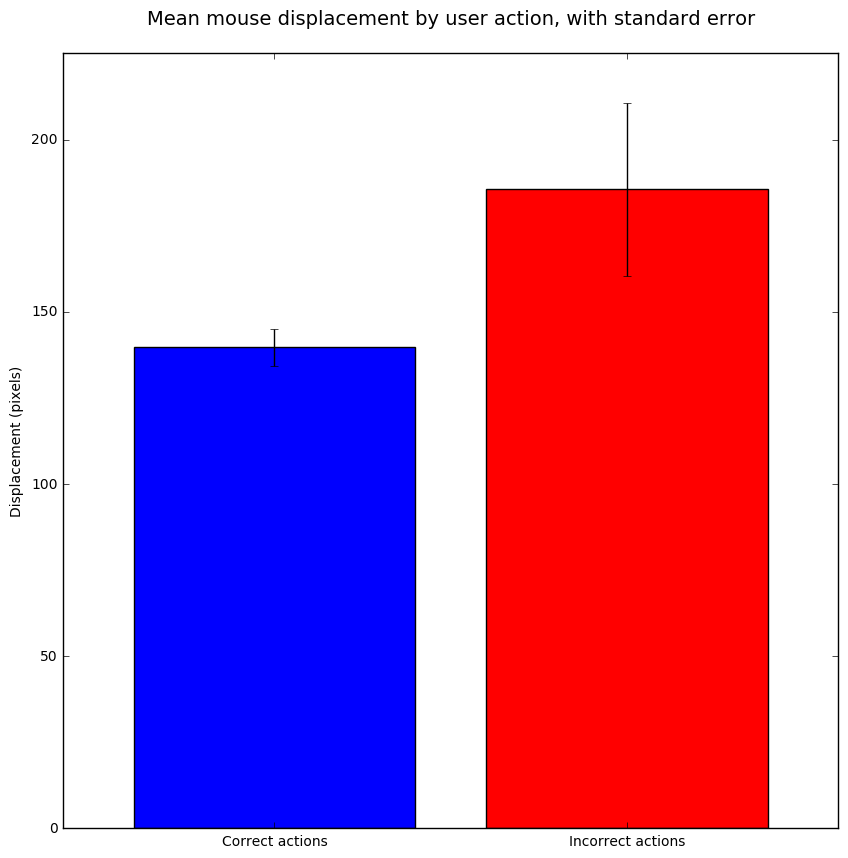

In [683]:
plt.figure(figsize=(10,10))

print 'CORRECT ACTIONS - MEAN MOUSE MVMT'
mean, sd, se, conf  = get_stats( df[df.action == df.image].mouse )

plt.bar( 1, mean, label = 'correct actions', color='blue' )
plt.errorbar( 1.4, mean, se, c='black' )

print '\nINCORRECT ACTIONS - MEAN MOUSE MVMT'
mean, sd, se, conf = get_stats( df[df.action != df.image].mouse )

plt.bar( 2, mean, label = 'incorrect actions', color='red' )
plt.errorbar( 2.4, mean, se, c='black' )

plt.xlim([.8, 3])   
plt.xticks([1.4, 2.4], ['Correct actions', 'Incorrect actions'])
plt.title("Mean mouse displacement by user action, with standard error\n", fontsize=14)
plt.ylabel("Displacement (pixels)")
plt.ylim([0,225])
plt.show()

CORRECT IMAGES - MEAN MOUSE MVMT
mean: 120.765396372
SD: 127.937623571
SE: 6.33385618164
95%: 12.414358116

INCORRECT IMAGES - MEAN MOUSE MVMT
mean: 175.91615179
SD: 141.880660329
SE: 8.49417295007
95%: 16.6485789821


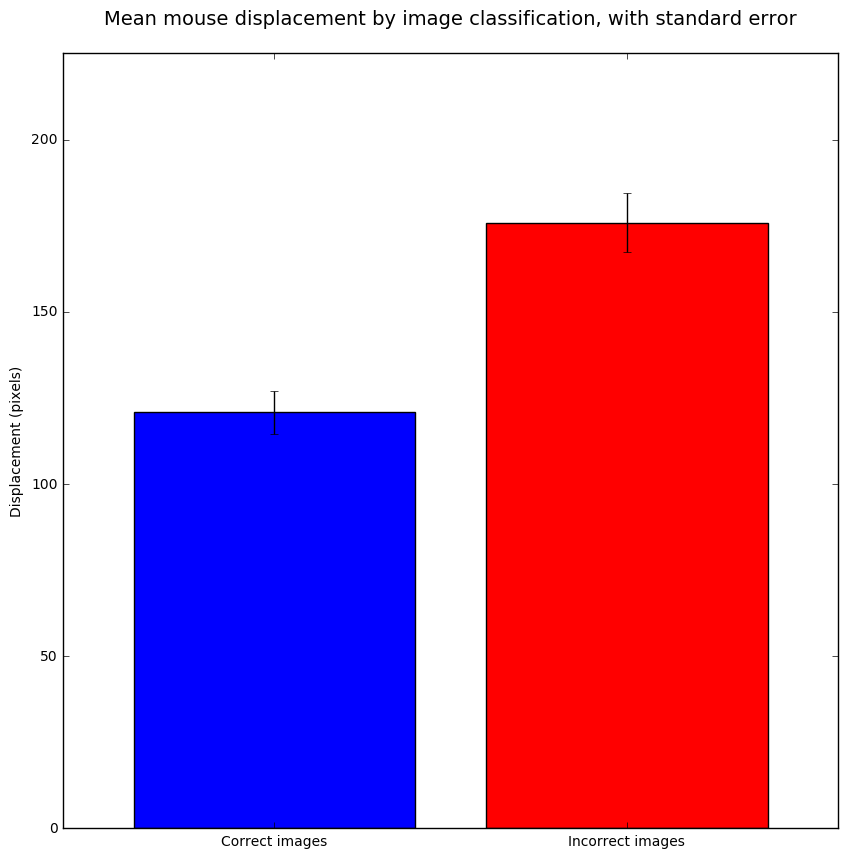

In [684]:
plt.figure(figsize=(10,10))

print 'CORRECT IMAGES - MEAN MOUSE MVMT'
mean, sd, se, conf = get_stats ( df[df.image == True].mouse )

plt.bar( 1, mean, label = 'correct images', color='blue' )
plt.errorbar( 1.4, mean, se, c='black' )

print '\nINCORRECT IMAGES - MEAN MOUSE MVMT'
mean, sd, se, conf = get_stats ( df[df.action == False].mouse )

plt.bar( 2, mean, label = 'incorrect images', color='red' )
plt.errorbar( 2.4, mean, se, c='black' )

plt.xlim([.8, 3])   
plt.xticks([1.4, 2.4], ['Correct images', 'Incorrect images'])
plt.title("Mean mouse displacement by image classification, with standard error\n", fontsize=14)
plt.ylabel("Displacement (pixels)")
plt.ylim([0,225])
plt.show()

CORRECT ACTIONS - MEAN MOUSE MVMT BY CATEGORY
owl
mean: 150.630851026
SD: 133.319787759
SE: 10.3165949125
95%: 20.2205260284

elvis
mean: 141.280953919
SD: 140.191658742
SE: 11.1885124154
95%: 21.9294843342

hot_dog
mean: 131.319614634
SD: 137.385592806
SE: 11.0350763655
95%: 21.6287496764

dog
mean: 134.987801272
SD: 132.793103948
SE: 10.2452103955
95%: 20.0806123753


INCORRECT ACTIONS - MEAN MOUSE MVMT BY CATEGORY
owl
mean: 156.002090046
SD: 210.440854453
SE: 121.498083967
95%: 238.136244575

elvis
mean: 132.900131436
SD: 135.362668464
SE: 37.5428493793
95%: 73.5839847835

hot_dog
mean: 247.081118458
SD: 134.652397398
SE: 34.7670995101
95%: 68.1435150397

dog
mean: 111.071945699
SD: 9.02165785184
SE: 6.37927544458
95%: 12.5033798714



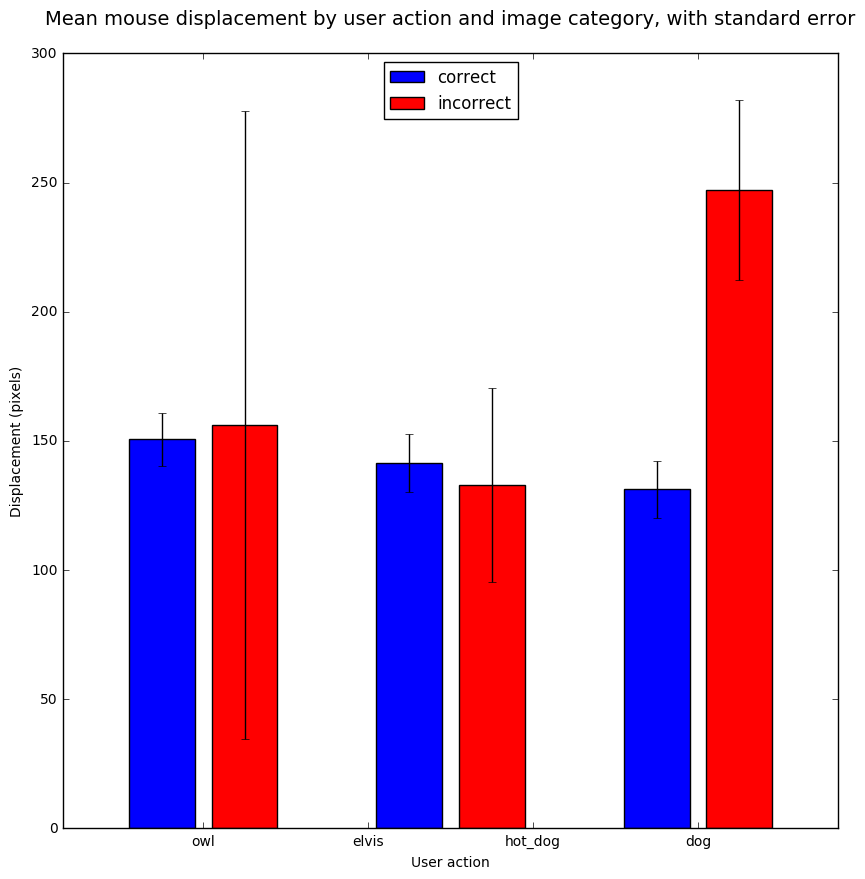

In [679]:
plt.figure( figsize = (10, 10))

correct_action_mean = []
incorrect_action_mean = []
correct_action_se = []
incorrect_action_se = []


print 'CORRECT ACTIONS - MEAN MOUSE MVMT BY CATEGORY'
for category in df.cat.unique().tolist():
    print "%s" % category
    mean, sd, se, conf = get_stats( df[(df.action == df.image) & (df.cat == category)].mouse )
    correct_action_mean.append(mean)
    correct_action_se.append(se)
    print
    
print '\nINCORRECT ACTIONS - MEAN MOUSE MVMT BY CATEGORY'
for category in df.cat.unique().tolist():
    print "%s" % category
    mean, sd, se, conf = get_stats( df[(df.action != df.image) & (df.cat == category)].mouse )
    incorrect_action_mean.append(mean)
    incorrect_action_se.append(se)
    print

plt.bar([0, 1.5, 3, 4.5], correct_action_mean, width = .4, label = 'correct', color='blue' )
plt.errorbar([0.2, 1.7, 3.2, 4.7], correct_action_mean, correct_action_se, c='black', ls='none' )

plt.bar([0.5, 2, 3.5, 5], incorrect_action_mean, width = .4, label = 'incorrect', color='red' )
plt.errorbar([0.7 ,2.2, 3.7, 5.2], incorrect_action_mean, incorrect_action_se, c='black', ls='none' )

plt.xlim([-.4, 4.3])   
plt.xticks(np.linspace(0.45,3.45, 4), df.cat.unique().tolist())
plt.legend(loc=9)
plt.title("Mean mouse displacement by user action and image category, with standard error\n", fontsize=14)
plt.xlabel("User action")
plt.ylabel("Displacement (pixels)")
plt.ylim([0,300])
plt.show()

CORRECT IMAGES - MEAN MOUSE MVMT BY CATEGORY
owl
mean: 137.721611764
SD: 130.089930423
SE: 13.2086311978
95%: 25.8889171477

elvis
mean: 113.581589042
SD: 126.859572795
SE: 12.0955856748
95%: 23.7073479226

hot_dog
mean: 114.926537982
SD: 127.496603105
SE: 11.5906002823
95%: 22.7175765533

dog
mean: 118.914993601
SD: 128.001138892
SE: 14.310962388
95%: 28.0494862805


INCORRECT IMAGES - MEAN MOUSE MVMT BY CATEGORY
owl
mean: 168.004959594
SD: 138.259151127
SE: 16.1820096583
95%: 31.7167389302

elvis
mean: 190.24727799
SD: 148.685297265
SE: 19.1951893378
95%: 37.622571102

hot_dog
mean: 207.237672435
SD: 151.106422417
SE: 21.5866317739
95%: 42.3097982768

dog
mean: 148.743277966
SD: 134.667702204
SE: 14.1952222075
95%: 27.8226355267



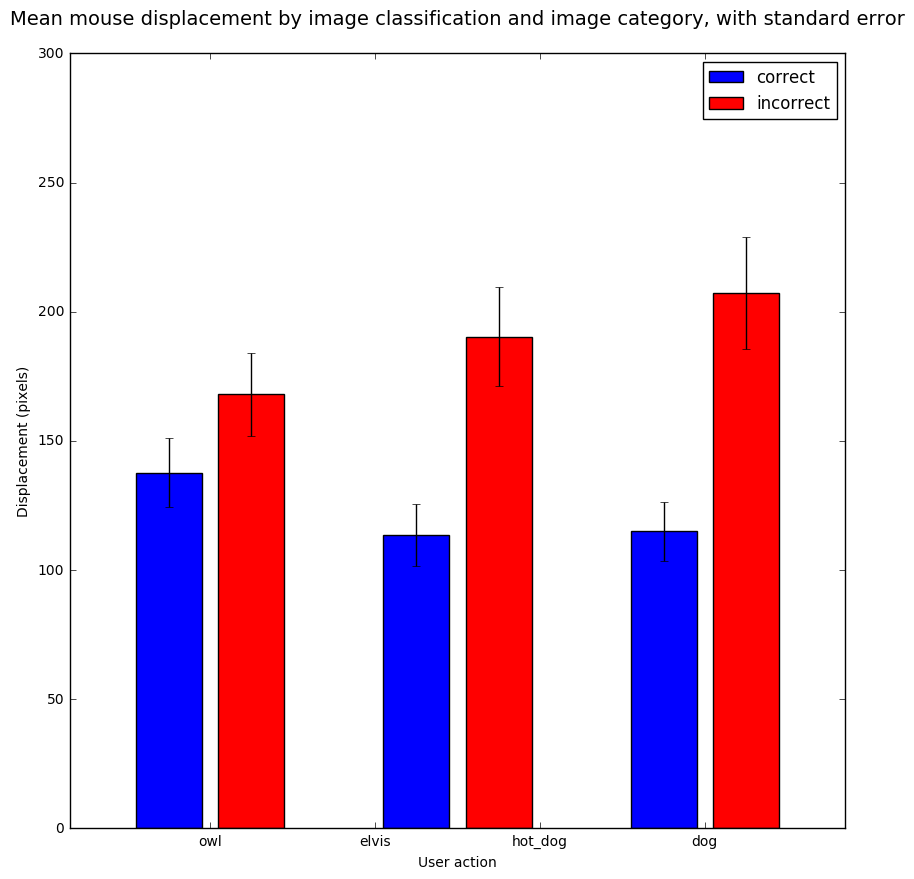

In [678]:
plt.figure( figsize = (10, 10))

correct_image_mean = []
incorrect_image_mean = []
correct_image_se = []
incorrect_image_se = []

print 'CORRECT IMAGES - MEAN MOUSE MVMT BY CATEGORY'
for category in df.cat.unique().tolist():
    print "%s" % category
    mean, sd, se, conf  = get_stats( df[(df.image == True) & (df.cat == category)].mouse )
    correct_image_mean.append(mean)
    correct_image_se.append(se)
    print
print '\nINCORRECT IMAGES - MEAN MOUSE MVMT BY CATEGORY'
for category in df.cat.unique().tolist():
    print "%s" % category
    mean, sd, se, conf = get_stats( df[(df.image == False) & (df.cat == category)].mouse )
    incorrect_image_mean.append(mean)
    incorrect_image_se.append(se)
    print
    
plt.bar([0, 1.5, 3, 4.5], correct_image_mean, width = .4, label = 'correct', color='blue' )
plt.errorbar([0.2, 1.7, 3.2, 4.7], correct_image_mean, correct_image_se, c='black', ls='none' )

plt.bar([0.5, 2, 3.5, 5], incorrect_image_mean, width = .4, label = 'incorrect', color='red' )
plt.errorbar([0.7 ,2.2, 3.7, 5.2], incorrect_image_mean, incorrect_image_se, c='black', ls='none' )

plt.xlim([-.4, 4.3])   
plt.xticks(np.linspace(0.45,3.45, 4), df.cat.unique().tolist())
plt.legend()
plt.title("Mean mouse displacement by image classification and image category, with standard error\n", fontsize=14)
plt.xlabel("User action")
plt.ylabel("Displacement (pixels)")
plt.ylim([0,300])
plt.show()

CORRECT AI LABEL - MEAN MOUSE MVMT
mean: 126.032663631
SD: 132.778047937
SE: 7.81047340808
95%: 15.3085278798

INCORRECT AI LABEL - MEAN MOUSE MVMT
mean: 155.865263506
SD: 141.299224752
SE: 9.50481443031
95%: 18.6294362834


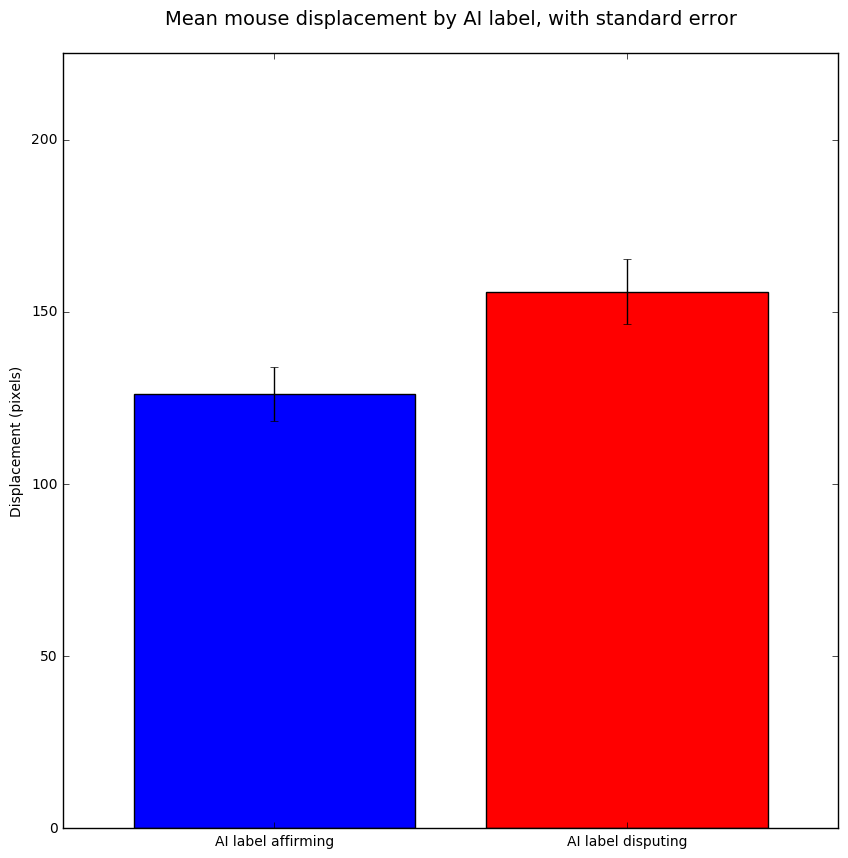

In [685]:
plt.figure(figsize = (10,10))

print 'CORRECT AI LABEL - MEAN MOUSE MVMT'
mean, sd, se, conf = get_stats ( df[(df.flag == True)].mouse )

plt.bar( 1, mean, label = 'category', color='blue' )
plt.errorbar( 1.4, mean, se, c='black' )

print '\nINCORRECT AI LABEL - MEAN MOUSE MVMT'
mean, sd, se, conf = get_stats( df[(df.flag == False)].mouse )

plt.bar( 2, mean, label = 'category', color='red' )
plt.errorbar( 2.4, mean, se, c='black' )

plt.xlim([.8, 3])   
plt.xticks([1.4, 2.4], ['AI label affirming', 'AI label disputing'])
plt.title("Mean mouse displacement by AI label, with standard error\n", fontsize=14)
plt.ylabel("Displacement (pixels)")
plt.ylim([0,225])
plt.show()

CORRECT AI LABEL - MEAN MOUSE MVMT BY CATEGORY
owl
mean: nan
SD: nan
SE: nan
95%: nan
elvis
mean: 125.01698136
SD: 133.03430983
SE: 13.0450873423
95%: 25.568371191
hot_dog
mean: 108.493237173
SD: 125.443627192
SE: 12.6717199206
95%: 24.8365710443
dog
mean: 147.003867643
SD: 138.9167673
SE: 14.8934407522
95%: 29.1911438743

INCORRECT AI LABEL - MEAN MOUSE MVMT BY CATEGORY
owl
mean: nan
SD: nan
SE: nan
95%: nan
elvis
mean: 165.258263826
SD: 146.676308375
SE: 18.0546054892
95%: 35.3870267588
hot_dog
mean: 186.505830587
SD: 148.458101976
SE: 17.4959551049
95%: 34.2920720056
dog
mean: 121.816361688
SD: 123.93581616
SE: 13.603723147
95%: 26.6632973682


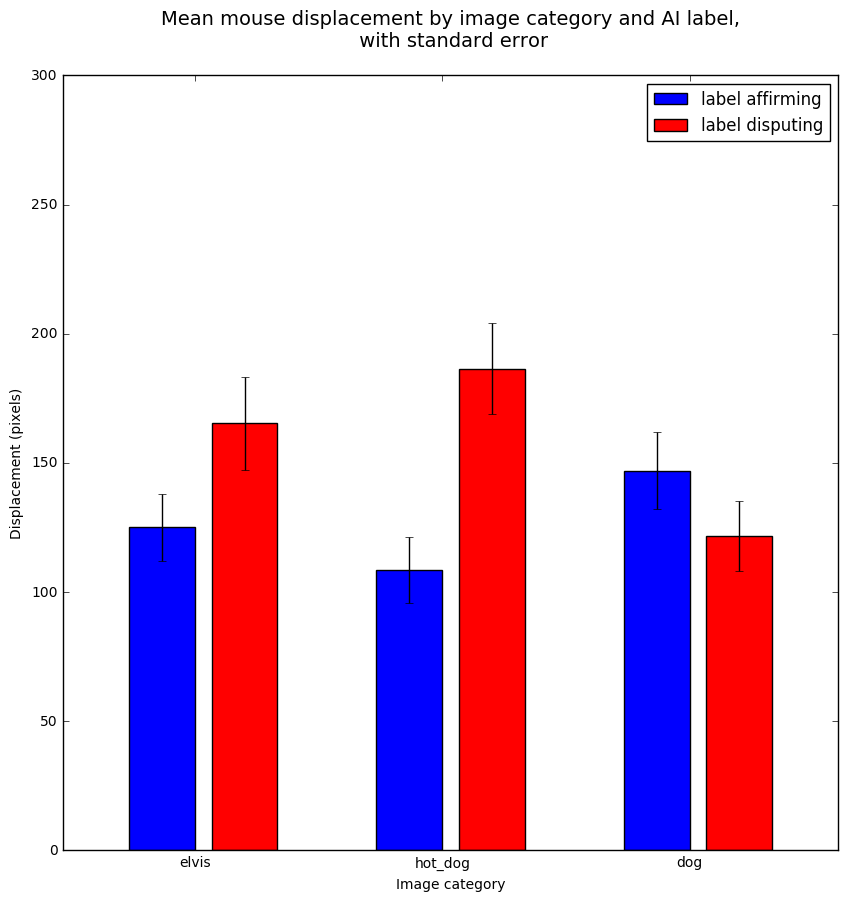

In [676]:
plt.figure(figsize = (10,10))

correct_means = []
incorrect_means = []
correct_se = []
incorrect_se = []

print 'CORRECT AI LABEL - MEAN MOUSE MVMT BY CATEGORY'
for i, category in enumerate(df.cat.unique().tolist()):
    print "%s" % category
    mean, sd, se, conf = get_stats( df[(df.flag) & (df.cat == category)].mouse )
    
    correct_means.append(mean)
    correct_se.append(se)
    
print '\nINCORRECT AI LABEL - MEAN MOUSE MVMT BY CATEGORY'
for i, category in enumerate(df.cat.unique().tolist()):
    print "%s" % category
    mean, sd, se, conf = get_stats( df[(df.flag == False ) & (df.cat == category)].mouse )
    
    incorrect_means.append(mean)
    incorrect_se.append(se)

plt.bar([0, 1.5, 3], correct_means[1:], 0.4, label = 'label affirming', color='blue')
plt.bar([0.5, 2, 3.5], incorrect_means[1:], 0.4, label = 'label disputing', color='red')

plt.errorbar([0.2, 1.7, 3.2],  correct_means[1:], correct_se[1:], c='black', ls='none' )
plt.errorbar([0.7 ,2.2, 3.7], incorrect_means[1:], incorrect_se[1:], c='black', ls='none' )
    
plt.xlim([-.4, 4.3])
plt.xticks(np.linspace(0.4, 3.4, 3), df.cat.unique().tolist()[1:])
plt.title("Mean mouse displacement by image category and AI label,\n with standard error\n", fontsize=14)
plt.ylabel("Displacement (pixels)")
plt.xlabel("Image category")
plt.ylim([0,300])
plt.legend()
plt.show()

MEAN MOUSE MVMT BY CATEGORY
owl
mean: 150.725637597
SD: 134.101596518
SE: 10.2851229478
95%: 20.1588409776

elvis
mean: 140.640067494
SD: 139.455773986
SE: 10.695769614
95%: 20.9637084434

hot_dog
mean: 141.533864972
SD: 140.662669979
SE: 10.7883343112
95%: 21.1451352499

dog
mean: 134.706438265
SD: 132.032165722
SE: 10.1264048511
95%: 19.8477535081



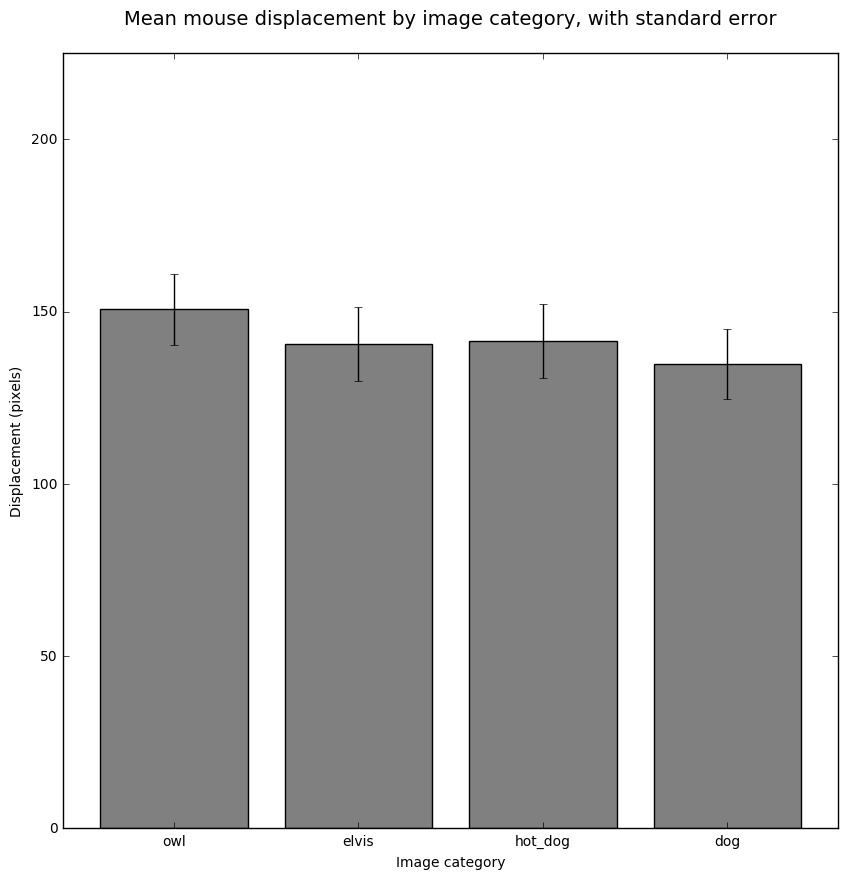

In [687]:
plt.figure(figsize = (10,10))

print 'MEAN MOUSE MVMT BY CATEGORY'

for i, category in enumerate(df.cat.unique().tolist()):
    print "%s" % category
    mean, sd, se, conf = get_stats( df[(df.cat == category)].mouse )
    
    plt.bar( i, mean, label = 'category', color='grey' )
    plt.errorbar( i+.4, mean, se, c='black' )
    
    print

plt.xlim([-.2, 4])   
plt.xticks(np.linspace(.4, 3.4, 4), df.cat.unique().tolist())
plt.title("Mean mouse displacement by image category, with standard error\n", fontsize=14)
plt.ylabel("Displacement (pixels)")
plt.xlabel("Image category")
plt.ylim([0,225])
plt.show()

In [460]:
# Identify conditions for each user
df['cond'] = df.apply(lambda x: classify_condition(x), axis = 1)
df['cond2'] = df.apply(lambda x: classify_condition2(x), axis = 1)
df.head()

,action,cat,device,flag,image,mouse,name,cond,cond2
0,False,owl,mouse,None,False,234.339093,MDR,imgF_aiF,aligned
1,False,owl,mouse,None,False,70.050022,MDR,imgF_aiF,aligned
2,False,owl,mouse,None,False,299.203970,MDR,imgF_aiF,aligned
3,True,owl,mouse,None,True,344.025017,MDR,imgT_aiF,not-aligned
4,False,owl,mouse,None,False,303.758277,MDR,imgF_aiF,aligned


In [461]:
# Remove owls
df_owl_only = df.loc[df.cat == 'owl']
df_nowl = df.loc[df.cat != 'owl']
df_nowl.head()

,action,cat,device,flag,image,mouse,name,cond,cond2
10,True,elvis,mouse,True,True,373.358636,MDR,imgT_aiT,aligned
11,True,elvis,mouse,True,True,377.229068,MDR,imgT_aiT,aligned
12,True,elvis,mouse,True,True,25.612497,MDR,imgT_aiT,aligned
13,False,elvis,mouse,True,True,159.904923,MDR,imgT_aiT,aligned
14,False,elvis,mouse,False,False,113.882625,MDR,imgF_aiF,aligned


In [462]:
# Convert to split format for 4 conditions
split4 = df_nowl.groupby(['name', 'cond'])['mouse'].mean()
split4_ = split4.unstack()
split4 = split4.reset_index()
split4_

cond,imgF_aiF,imgF_aiT,imgT_aiF,imgT_aiT
name,,,,
HCS,56.897479,114.001188,58.254485,124.417266
I.W.,147.038094,303.663440,132.815047,110.276143
J.Q,69.779818,198.525469,162.342486,128.133073
JF,168.092094,364.523057,175.125299,199.745079
KS,230.327719,402.735624,16.215102,92.806797
LR,282.108598,154.246899,131.452470,120.179456
MDR,195.849877,361.761223,149.648516,111.931398
MDR-touchpad,264.973072,NaN,64.656786,94.843734
P,190.641773,268.233618,185.866157,112.823941


In [463]:
# To CSV
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M_")
df.to_csv(timestamp + 'stacked.csv')
split4_.to_csv(timestamp + 'split4.csv')

In [464]:
# Convert to split format for 2 conditions
split2 = df_nowl.groupby(['name', 'cond2'])['mouse'].mean()
split2_ = split2.unstack()
split2 = split2.reset_index()
split2_

cond2,aligned,not-aligned
name,,
HCS,90.657372,86.127837
I.W.,129.392358,166.984726
J.Q,98.956446,180.433978
JF,191.112446,246.149458
KS,127.187028,80.635189
LR,171.702365,137.151077
MDR,143.598749,210.252146
MDR-touchpad,170.456773,64.656786
P,156.401927,235.286634


In [465]:
# To CSV
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M_")
# df.to_csv(timestamp + 'stacked2.csv')
split2_.to_csv(timestamp + 'split2.csv')

In [466]:
# For 2 conditions, compute standard deviation and standard error
split2 = split2.drop(18, axis = 0)
for_bar2 = split2.groupby('cond2').mean().reset_index()
std = (split2.groupby('cond2').std().values)
error = std / np.sqrt(len(split2.name.unique()))*1.96

In [467]:
# T-test between aligend and non-aligned
# st.ttest_ind(split2.mouse[split2.cond2 == 'aligned'], split2.mouse[split2.cond2 == 'not-aligned'], axis=0, equal_var=True)\
t, prob = st.ttest_rel(split2.mouse[split2.cond2 == 'aligned'], split2.mouse[split2.cond2 == 'not-aligned'], axis=0)
print prob

0.568755073329


In [196]:
for user in split4.name.tolist():
    if user not in split4[split4.cond == 'imgF_aiT'].name.tolist():
        print user
        
split4 = split4[split4.name != 'RG']
split4 = split4[split4.name != 'MDR-touchpad']

MDR-touchpad
MDR-touchpad
MDR-touchpad


In [198]:
split4.head()

,name,cond,mouse
0,HCS,imgF_aiF,56.897479
1,HCS,imgF_aiT,114.001188
2,HCS,imgT_aiF,58.254485
3,HCS,imgT_aiT,124.417266
4,I.W.,imgF_aiF,147.038094


In [206]:
for i, condition1 in enumerate(split4.cond.unique().tolist()):
    for condition2 in split4.cond.unique().tolist()[i:]:
        if condition1 != condition2:
            t, prob = st.ttest_rel(split4.mouse[split4.cond == condition1], split4.mouse[split4.cond == condition2], axis=0)
            print 'For %s and %s score: %f, p-value: %f' % (condition1, condition2, t, prob)

For imgF_aiF and imgF_aiT score: -1.291147, p-value: 0.216197
For imgF_aiF and imgT_aiF score: 2.294839, p-value: 0.036587
For imgF_aiF and imgT_aiT score: 3.047292, p-value: 0.008148
For imgF_aiT and imgT_aiF score: 2.714003, p-value: 0.016003
For imgF_aiT and imgT_aiT score: 3.078377, p-value: 0.007648
For imgT_aiF and imgT_aiT score: -0.025316, p-value: 0.980137


In [207]:
df

,action,cat,device,flag,image,mouse,name,cond,cond2
0,False,owl,mouse,None,False,234.339093,MDR,imgF_aiF,aligned
1,False,owl,mouse,None,False,70.050022,MDR,imgF_aiF,aligned
2,False,owl,mouse,None,False,299.203970,MDR,imgF_aiF,aligned
3,True,owl,mouse,None,True,344.025017,MDR,imgT_aiF,not-aligned
4,False,owl,mouse,None,False,303.758277,MDR,imgF_aiF,aligned
5,True,owl,mouse,None,True,112.358199,MDR,imgT_aiF,not-aligned
6,True,owl,mouse,None,True,193.490120,MDR,imgT_aiF,not-aligned
7,True,owl,mouse,None,True,255.179486,MDR,imgT_aiF,not-aligned
8,False,owl,mouse,None,False,302.242076,MDR,imgF_aiF,aligned
9,False,owl,mouse,None,False,413.286973,MDR,imgF_aiF,aligned


In [265]:
from scipy.optimize import curve_fit
from scipy import asarray as ar,exp

n = len(x)                          #the number of data
mean = sum(x*y)/n                   #note this correction
sigma = sum(y*(x-mean)**2)/n        #note this correction

def gaus(x,a,x0,sigma):
    return a*exp(-(x-x0)**2/(2*sigma**2))

popt,pcov = curve_fit(gaus,x,y,p0=[1,mean,sigma])

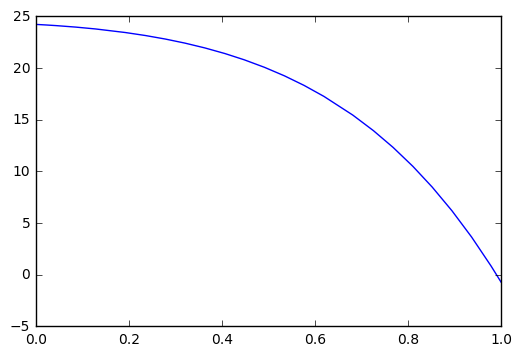

In [367]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

model = make_pipeline(PolynomialFeatures(5), Ridge())
model.fit(t, y)
y_plot = model.predict( t )
plt.plot( t, y_plot, linewidth=1) #, label="degree %d" % degree)

plt.legend(loc='lower left')

plt.show()

In [370]:
for i, row in df.iterrows():
    aligned_coords = []
    unaligned_coords = []
    aligned_times = []
    unaligned_times = []
    if row.cond2 == 'aligned':
        aligned_coords.append( all_coords[i] )
        aligned_times.append( all_times[i] )
    else:
        unaligned_coords.append( all_coords[i] )
        unaligned_times.append( all_times[i] )

x, y, t = create_flat_coords( aligned_coords, aligned_times )

25 25 25


In [372]:
print y

[[  0.00000000e+00]
 [  1.42608217e+01]
 [  2.13296943e+01]
 [  2.37591176e+01]
 [  2.77965622e+01]
 [  3.74179346e+01]
 [  4.18272844e+01]
 [  4.02513699e+01]
 [  3.36025628e+01]
 [  2.70768322e+01]
 [  2.05511016e+01]
 [  1.66233556e+01]
 [  1.52935942e+01]
 [  1.47370743e+01]
 [  1.43196844e+01]
 [  1.32681829e+01]
 [  1.15825698e+01]
 [  1.14434399e+01]
 [  1.05310683e+01]
 [  9.47956685e+00]
 [  7.65482381e+00]
 [  5.05683922e+00]
 [  3.23209618e+00]
 [  7.73241552e-01]
 [  5.00710584e-14]]


In [362]:
def create_flat_coords ( all_coords, all_times ):
    x = []
    y = []
    t = []
    for i, coords in enumerate(all_coords):
        x.extend(coords[0].tolist())
        y.extend(coords[1].tolist())
        t.extend(all_times[i])

    y = [abs(y_) for y_ in y]

    x = np.asarray(x).reshape(len(x),1)
    y = np.asarray(y).reshape(len(x),1)
    t = np.asarray(t).reshape(len(x),1)

    print len(x), len(y), len(t)
    return x, y, t

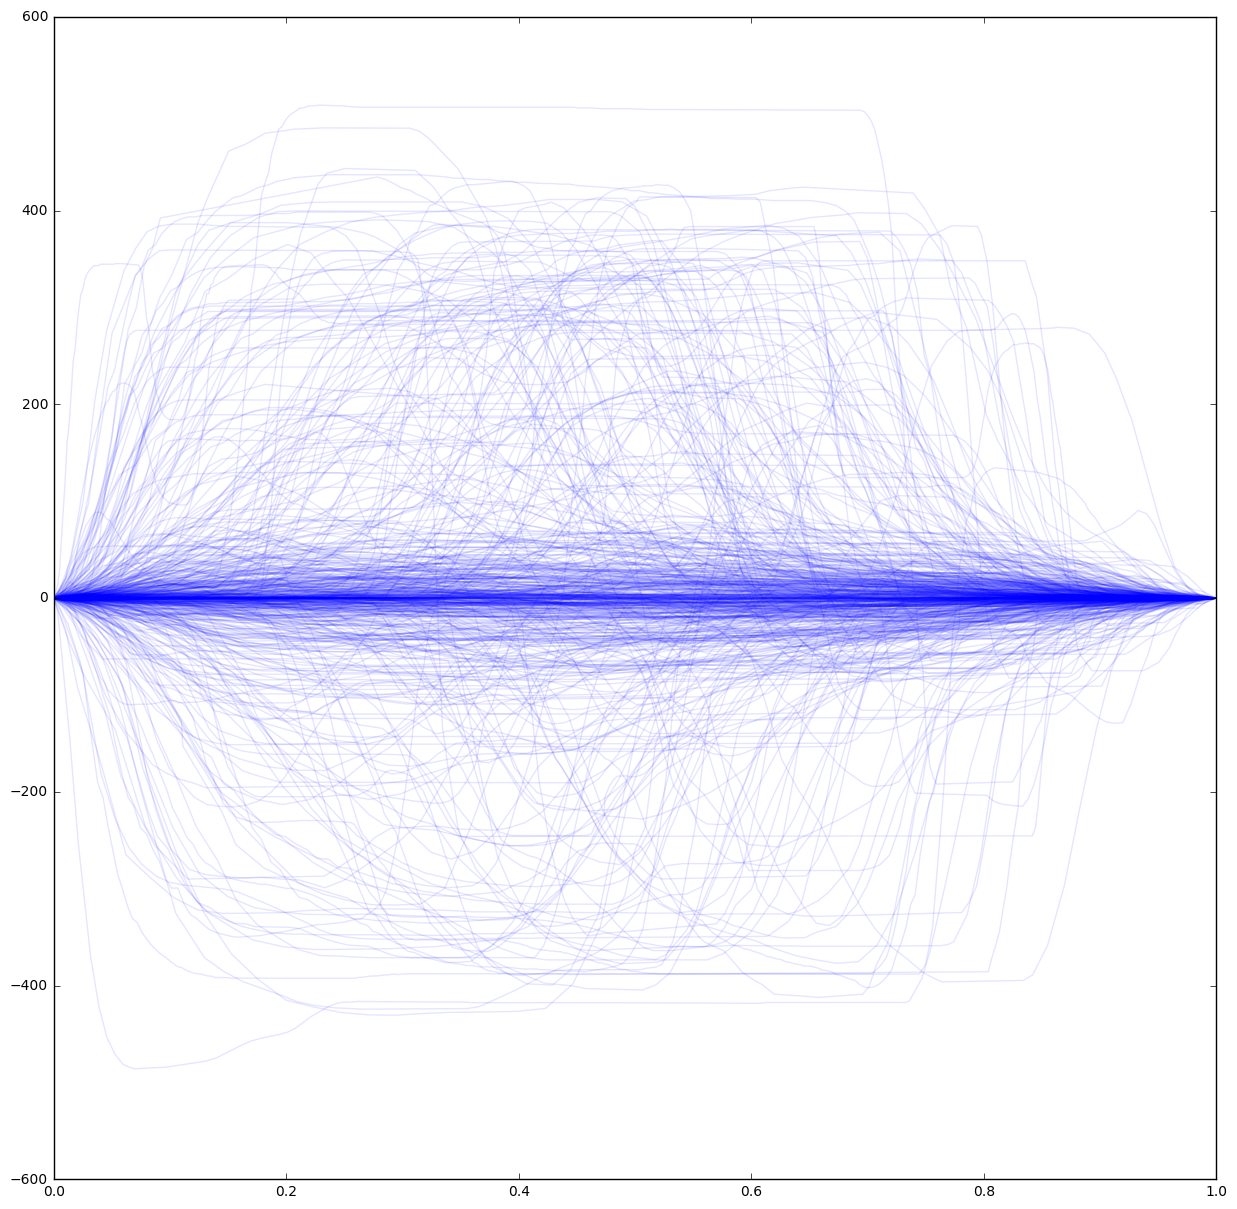

In [376]:
plt.figure(figsize=(15,15))

for i, trial in df.iterrows():
    if trial.cond2 == 'aligned':
    # print all_times[i].size, all_coords[i].size
        plt.plot(all_times[i], all_coords[i][1], alpha = 0.1, c = 'blue')
    # else:
    #    plt.plot(all_times[i], -abs(all_coords[i][1]), alpha = 0.1, c = 'red')

plt.show()

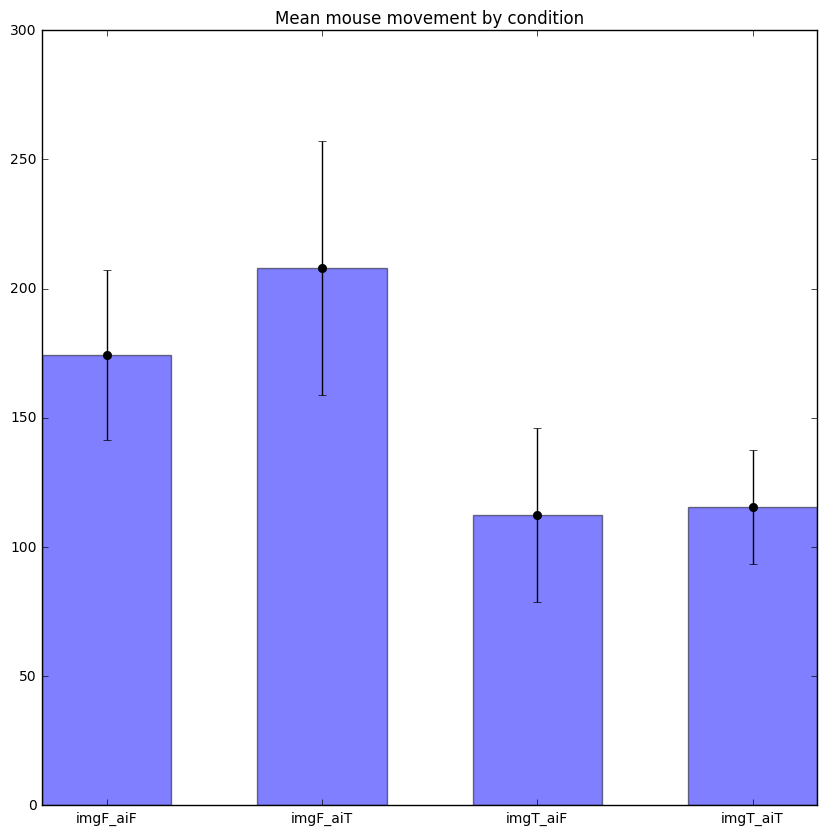

In [36]:
names = for_bar.cond.values
values = for_bar.mouse.values

plt.figure(figsize=(10,10))

plt.bar([0,1,2,3], values, .6, 0, tick_label = names, alpha = 0.5, align = 'center')
plt.errorbar([0,1,2,3], values, yerr=error, fmt='o', c='black')
plt.title('Mean mouse movement by condition')
plt.show()

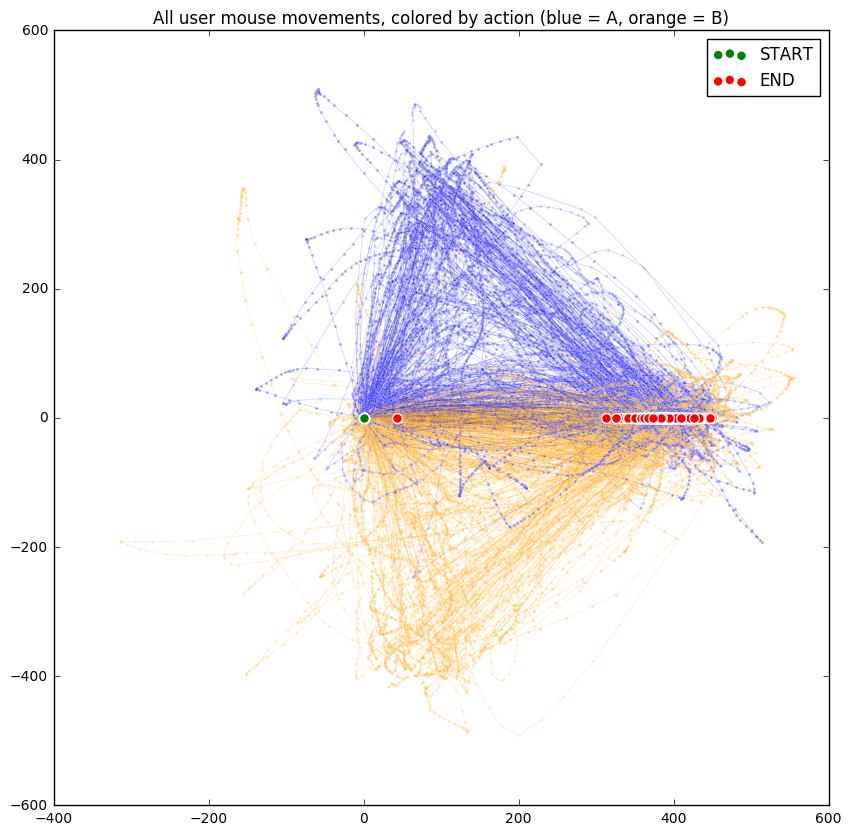

In [32]:
# Plot to check for first user
coords_user = all_coords[:]
color = ['blue', 'orange']
plt.figure(figsize=(10,10))

for i, coords in enumerate(coords_user):
    plt.plot(coords[0,:], coords[1,:] , lw = .5, c = color[action[i]], alpha = 0.2, ms=2, mec='white', marker='o', zorder=1)
    plt.scatter(coords[0,0], coords[1,0], c='green', s=50, lw = 1, edgecolors='white', label='START', zorder=10)
    plt.scatter(coords[0,-1], coords[1,-1], c='red', s=50, lw = 1, edgecolors='white', label='END', zorder=10)
    
    if i == 0:
        plt.legend()

plt.title('All user mouse movements, colored by action (blue = A, orange = B)')

plt.show()



HCS
I.W.
J.Q
JF
KS
LR
MDR
MDR-touchpad
P
RG
SAW
SH
SM
SR
TM
X to the Z Xzibit 
ssa
vs


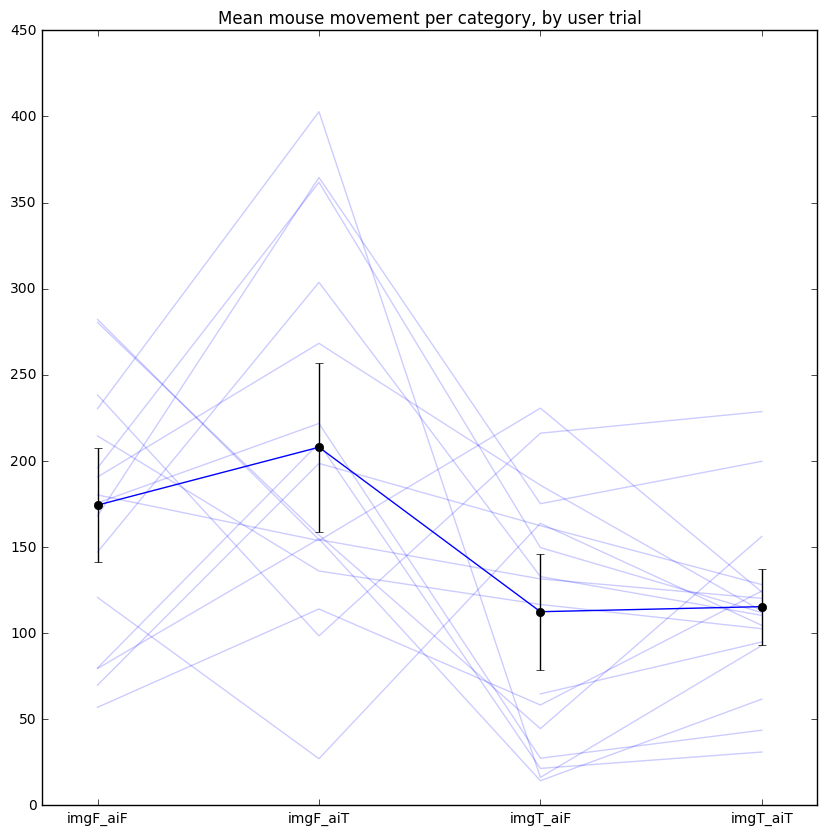

In [37]:

plt.figure(figsize=(10,10))

for i, user in split_.reset_index().iterrows():
    print user[0]
    plt.plot([1,2,3,4], [user[1], user[2], user[3], user[4]], alpha = 0.2, c="blue" )

plt.plot([1,2,3,4], values, c='blue')
plt.errorbar([1,2,3,4], values, yerr=error, fmt='o', c='black')
plt.xlim([.75,4.25])
plt.xticks([1,2,3,4], split_.columns)
plt.title("Mean mouse movement per category, by user trial")
plt.show()


In [38]:
values

array([ 174.30950258,  207.90308329,  112.40680216,  115.35414245])